In [1]:
from algorithms import UCB
import numpy as np
import sys
from util.constants import JointFeatureMode
from util import utility_functions

import logging
logging.basicConfig(stream=sys.stdout, format='%(asctime)s | %(name)s (%(levelname)s):\t %(message)s')

In [4]:
repitition_num = 1
parametrizations = utility_functions.get_parameterization_saps()
features = utility_functions.get_features_saps()
running_time = utility_functions.get_run_times_saps()
regret_ucb = np.zeros((repitition_num, features.shape[0]))
execution_time_ucb = np.zeros(repitition_num)

## Upper Confidence Bound (baseline)

In [18]:
for rep in range(repitition_num):
    print(f"Rep no.: {rep + 1}")
    ucb = UCB(random_state=np.random.RandomState(515), parametrizations=parametrizations, features=features, running_time=running_time)
    ucb.run()
    regret_ucb[rep] = ucb.get_regret()
    execution_time_ucb[rep] = ucb.execution_time

Rep no.: 1
2022-10-15 12:21:16,105 | BaseAlgorithm (INFO):	 Initializing...
2022-10-15 12:21:38,054 | UpperConfidenceBound (INFO):	 Running algorithm...
2022-10-15 12:22:29,734 | UpperConfidenceBound (INFO):	 Algorithm Finished...


In [19]:
# regret = ucb.get_regret().astype("float64")
print(regret_ucb.shape)
np.savetxt('Regret_results//regret_ucb.txt', regret_ucb)

(1, 5000)


## Plotting results

C:\Users\sshiv\AppData\Local\Temp\ipykernel_5236\2776163517.py:22: RuntimeWarning: divide by zero encountered in log
  ax[solver_index, size_index].plot(np.log(np.mean(cum_reg, axis=0)), color=colors[index], label=f"{algorithm}")


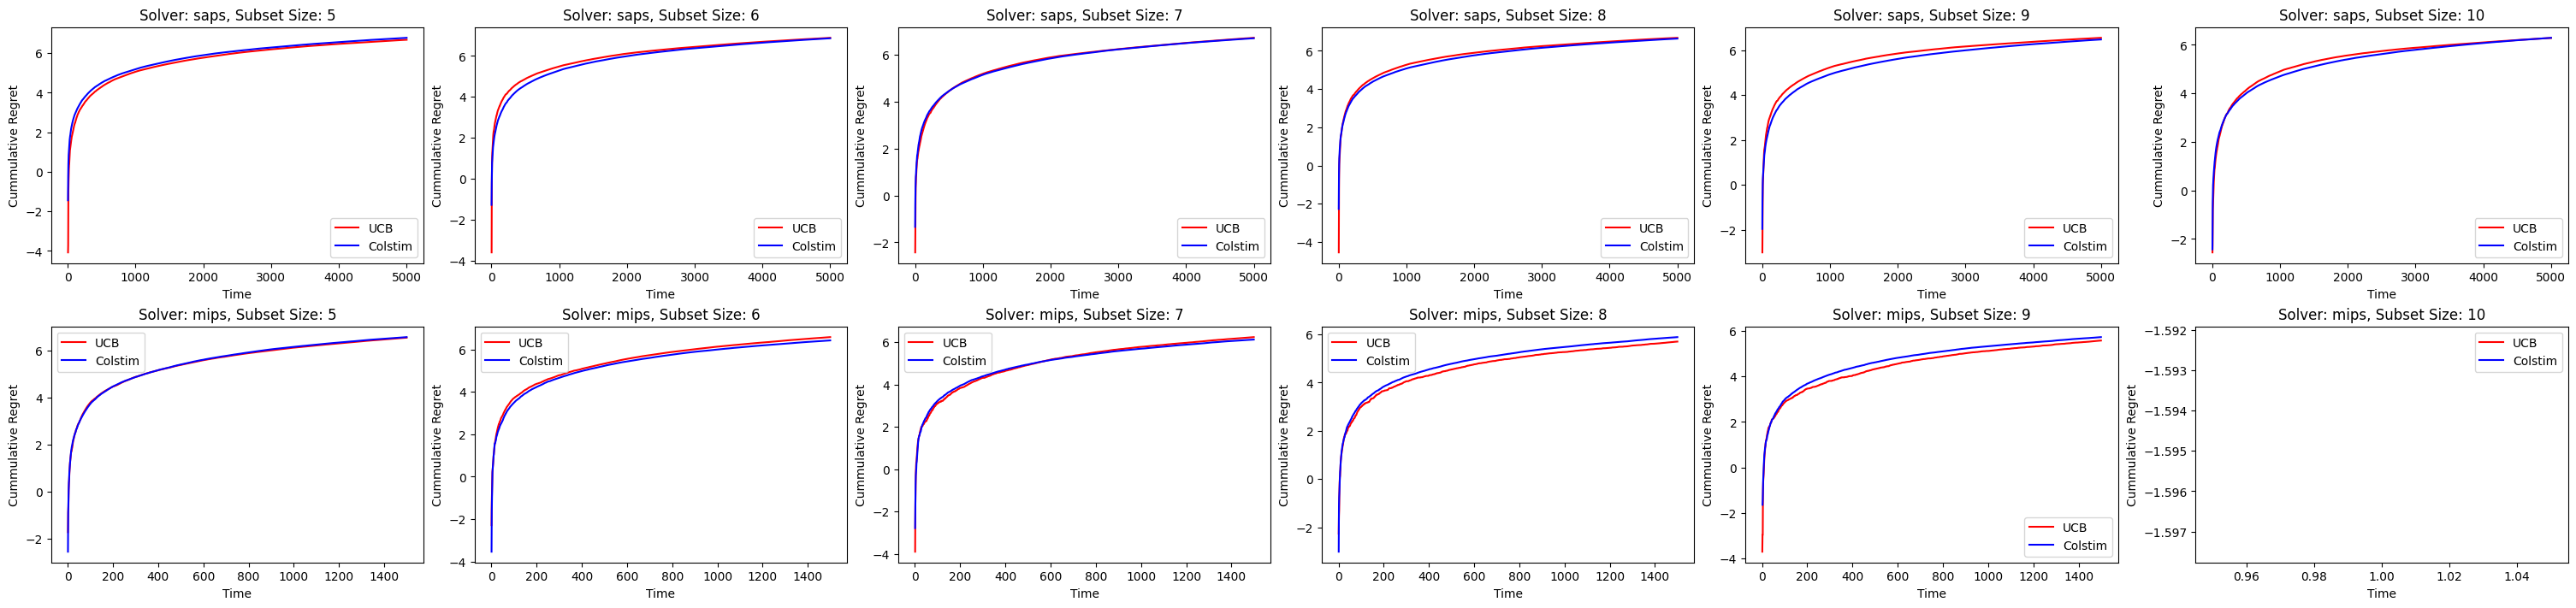

In [2]:
from algorithms import regret_minimizing_algorithms
from util.constants import Solver
from util.metrics import compute_cumm_reg
import matplotlib.pyplot as plt
import numpy as np

algorithms = [
        algorithm.__name__ for algorithm in regret_minimizing_algorithms
    ]

solvers = [solver.value for solver in Solver]
subset_size = [5, 6, 7, 8, 9, 10]
colors = ["red", "blue"]

fig, ax = plt.subplots(len(solvers), len(subset_size), figsize=(30, 7), constrained_layout=True)
for solver_index, solver in enumerate(solvers):
    for size_index, size in enumerate(subset_size):
        for index, algorithm in enumerate(algorithms):
            regret = np.load(f"Regret_results_2//regret_{algorithm}_{solver}_{size}.npy")
            cum_reg = compute_cumm_reg(regret)
            
            ax[solver_index, size_index].plot(np.log(np.mean(cum_reg, axis=0)), color=colors[index], label=f"{algorithm}")
            # ax[solver_index, size_index].fill_between(
            #     range(len(cum_reg[0])), 
            #     np.log(np.mean(cum_reg, axis=0)-np.std(cum_reg, axis=0))/np.sqrt(len(cum_reg)), 
            #     np.log(np.mean(cum_reg, axis=0)+np.std(cum_reg, axis=0))/np.sqrt(len(cum_reg)), 
            #     color=colors[index],
            #     alpha=0.2
            # )
            ax[solver_index, size_index].legend()
            ax[solver_index, size_index].set_ylabel("Cummulative Regret")
            ax[solver_index, size_index].set_xlabel("Time")
            ax[solver_index, size_index].set_title(f"Solver: {solver}, Subset Size: {size}")
plt.show()
            

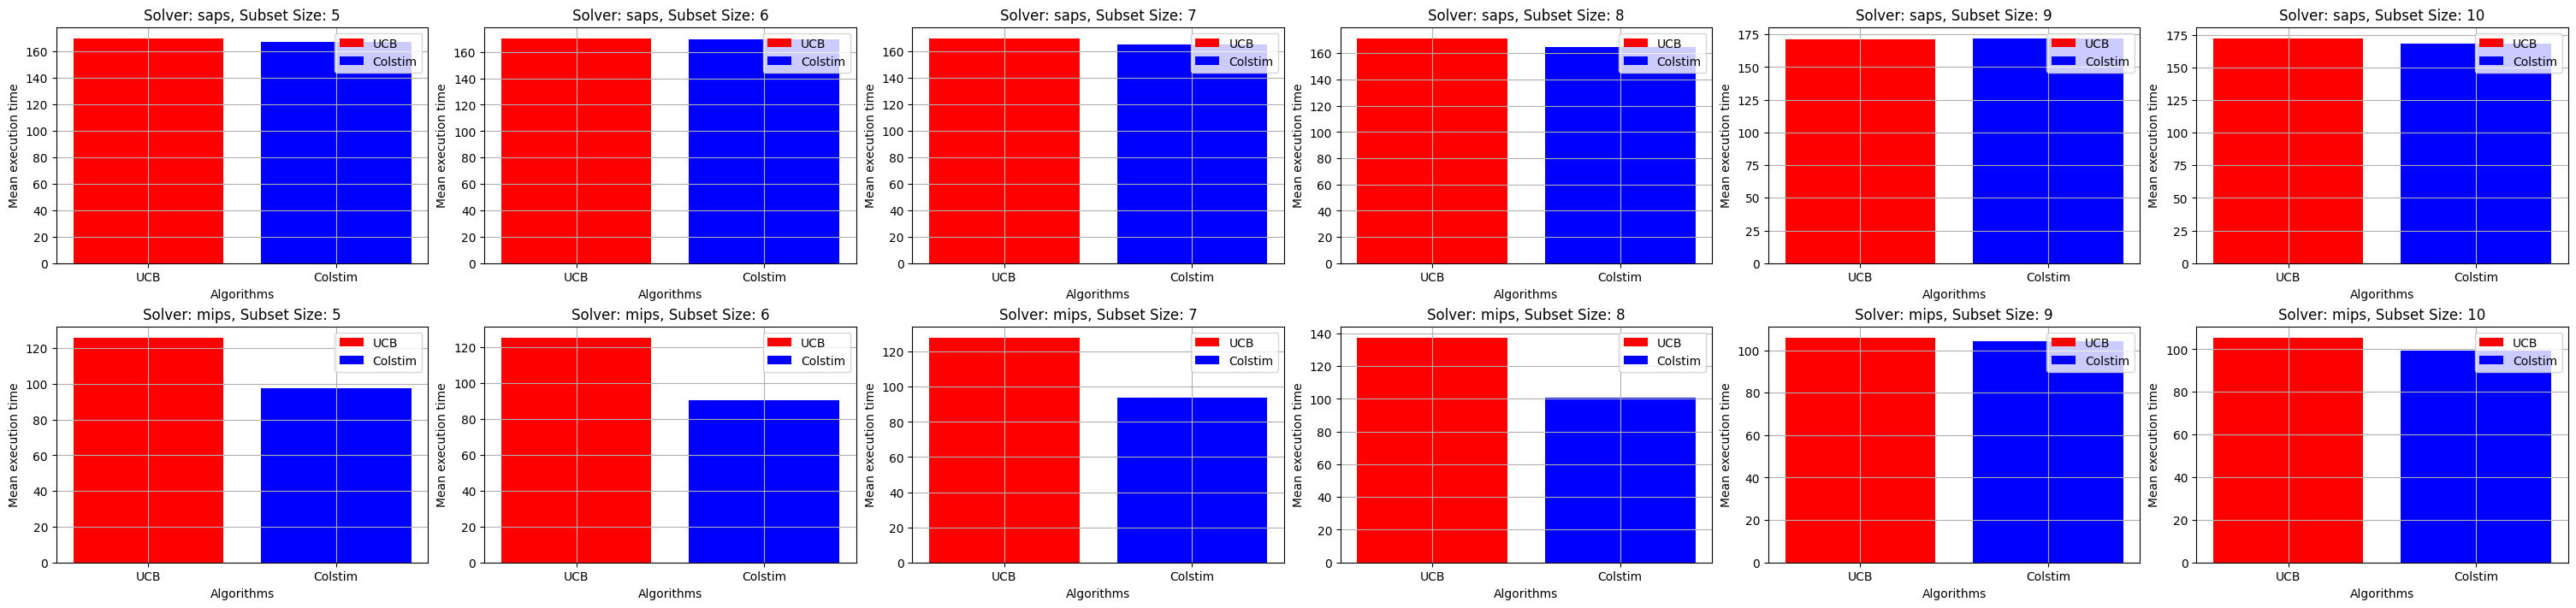

In [3]:
import seaborn as sns

fig, ax = plt.subplots(len(solvers), len(subset_size), figsize=(30, 7), constrained_layout=True)
for solver_index, solver in enumerate(solvers):
    for size_index, size in enumerate(subset_size):
        for index, algorithm in enumerate(algorithms):
            execution_time = np.load(f"Execution_times_results//execution_time_{algorithm}_{solver}_{size}.npy")
            
            ax[solver_index, size_index].bar(x=algorithm, height=execution_time.mean(), color=colors[index], label=f"{algorithm}")
            # ax[solver_index, size_index].fill_between(
            #     range(len(cum_reg[0])), 
            #     np.log(np.mean(cum_reg, axis=0)-np.std(cum_reg, axis=0))/np.sqrt(len(cum_reg)), 
            #     np.log(np.mean(cum_reg, axis=0)+np.std(cum_reg, axis=0))/np.sqrt(len(cum_reg)), 
            #     color=colors[index],
            #     alpha=0.2
            # )
            ax[solver_index, size_index].legend()
            ax[solver_index, size_index].set_ylabel("Mean execution time")
            ax[solver_index, size_index].set_xlabel("Algorithms")
            ax[solver_index, size_index].set_title(f"Solver: {solver}, Subset Size: {size}")
        ax[solver_index, size_index].grid()
plt.show()

# execution_time = np.load(f"Execution_times_results//execution_time_UCB_saps_5.npy")
# print(execution_time.shape)
# x = ['UCB']
# plt.bar(x=x, height=execution_time.mean())

## Testing MIPS

In [1]:
from util import utility_functions
import numpy as np
import sys
import logging
logging.basicConfig(stream=sys.stdout, format='%(asctime)s | %(name)s (%(levelname)s):\t %(message)s')

repitition_num = 1
parametrizations = utility_functions.get_parameterization_mips()
features = utility_functions.get_features_mips()
running_time = utility_functions.get_run_times_mips()
regret_colstim = np.zeros((repitition_num, features.shape[0]))
execution_time_colstim = np.zeros(repitition_num)

In [5]:
np.load(f"Regret_results//regret_UCB_saps_5.npy").shape

(10, 5000)